In [2]:
!pip install causalml

Defaulting to user installation because normal site-packages is not writeable
Processing /home/ns4486/.cache/pip/wheels/d7/16/cd/f9918ec891368bfcbbd4f6de9a612dfbe2b9d9c64e24c729a8/causalml-0.10.0-cp38-cp38-linux_x86_64.whl
  Using cached pyro_ppl-1.6.0-py3-none-any.whl (634 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)


ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: pytorch-lightning 0.9.0 has requirement tensorboard==2.2.0, but you'll have tensorboard 2.5.0 which is incompatible.
ERROR: pyro-ppl 1.6.0 has requirement torch>=1.8.0, but you'll have torch 1.5.0+cu101 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import causalml

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *




from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

In [2]:
import os, sys
import numpy as np
import pandas as pd
import pickle
import time
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

pd.set_option('display.max_columns', None)


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.explore_utils as eu

In [3]:
type_map = {
    'decision_date' : 'str',
    'filing_date' : 'str',
    'Court Name' : 'category',
    'Party of Appointing President' : 'category',
    'CIRCUIT' : 'category',
    'JURIS' : 'category',
    'NOS' : 'category',
    'ORIGIN' : 'category',
    'RESIDENC' : 'category',
    'CLASSACT' : 'category',
    'DEMANDED' : 'float64',
    'TERMDATE' : 'str',
    'DISP' : 'category',
    'PROCPROG' : 'category',
    'NOJ' : 'category',
    'AMTREC' : 'float64',
    'JUDGMENT' : 'category',
    'TAPEYEAR' : 'float64',
    'district' : 'category',
    'office' : 'category',
    'county' : 'category',
    'TRCLACT' : 'category',
    'PROSE' : 'category',
    'arbit' : 'category',
    'transoff' : 'category',
    'trmarb' : 'category',
    'ifp' : 'category',
    'statuscd' : 'category'
}

cols_to_drop = [
    'decision_date',
#     'filing_date',
    'TERMDATE',
    'TAPEYEAR'
]

df = pd.read_csv(
#     '/scratch/ayl316/ttml_mr_data/processed_data/cases.csv.zip', 
    '/scratch/ayl316/ttml_mr_data/processed_data_2/new_cases.csv.zip',
    dtype = type_map, 
    parse_dates = ['decision_date', 'filing_date', 'TERMDATE']
).rename(columns = {
    'Court Name' : 'court_name',
    'Party of Appointing President' : 'party'
}).drop(columns = cols_to_drop)


df['filing_year'] = pd.DatetimeIndex(df['filing_date']).year
df['filing_year'] = df['filing_year'].astype(str).astype('category')
df = df.drop(columns = ['filing_date'])

for col in ['party', 'TRCLACT', 'PROSE', 'arbit', 'transoff', 'trmarb', 'ifp', 'statuscd', 'filing_year']:
    if not '-8.0' in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('-8.0')
    df[col] = df[col].fillna('-8.0')

df['district_year'] = df['district'].astype(str) + '_' + df['filing_year'].astype(str)

df = df.replace('-8.0', np.NaN)
df = df.replace('-8', np.NaN)

df.loc[(df['CLASSACT'] == '-9.0'), 'CLASSACT'] = np.NaN
df.loc[(df['CLASSACT'] != '1.0'), 'CLASSACT'] = '0.0'
df['CLASSACT'] = df['CLASSACT'].fillna('0.0')

df['TRCLACT'] = df['TRCLACT'].cat.add_categories('0.0')
df['TRCLACT'] = df['TRCLACT'].fillna('0.0')

df.loc[(df['NOJ'] == '-9.0'), 'NOJ'] = np.NaN

df['AMTREC'] = df['AMTREC'].fillna(df['AMTREC'].mean())

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997522 entries, 0 to 1997521
Data columns (total 26 columns):
 #   Column         Dtype   
---  ------         -----   
 0   court_name     category
 1   party          category
 2   CIRCUIT        category
 3   JURIS          category
 4   NOS            category
 5   ORIGIN         category
 6   RESIDENC       category
 7   CLASSACT       category
 8   DEMANDED       float64 
 9   DISP           category
 10  PROCPROG       category
 11  NOJ            category
 12  AMTREC         float64 
 13  JUDGMENT       category
 14  district       category
 15  office         category
 16  county         category
 17  TRCLACT        category
 18  PROSE          category
 19  arbit          category
 20  transoff       category
 21  trmarb         category
 22  ifp            category
 23  statuscd       category
 24  filing_year    category
 25  district_year  object  
dtypes: category(23), float64(2), object(1)
memory usage: 93.5+ MB


In [5]:
# Check NULL percentage
def get_null_percent(df):
    return (df.shape[0] - df.count()) * 100 / df.shape[0]

In [6]:
get_null_percent(df)

court_name        0.000000
party             0.707827
CIRCUIT           0.000000
JURIS             0.000000
NOS               0.000000
ORIGIN            0.004205
RESIDENC         85.701384
CLASSACT          0.000000
DEMANDED          0.000000
DISP              0.000000
PROCPROG          0.000000
NOJ              27.950781
AMTREC            0.000000
JUDGMENT         23.854606
district          0.000000
office            0.000000
county            0.000000
TRCLACT           0.000000
PROSE            24.374100
arbit            98.375237
transoff         99.112601
trmarb           99.455826
ifp              81.808861
statuscd         29.193321
filing_year       0.000000
district_year     0.000000
dtype: float64

In [7]:
from copy import copy

cat_cols = [
    'NOJ',
#     'JUDGMENT',
    'PROSE',
#     'trmarb', (too many nulls)
    'CLASSACT',
    'JURIS',
    'TRCLACT',
#     'ifp', (too many nulls)
    'statuscd',
    'PROCPROG',
    'CIRCUIT',
#     'transoff', (too many nulls)
    'ORIGIN',
#     'arbit', (too many nulls)
    'office',
#     'court_name',
    'NOS',
    'district',
#     'TAPEYEAR',
#     'RESIDENC', (too many nulls)
    'DISP',
    'filing_year',
    'district_year'
]

numeric_cols = [
#     'DEMANDED',
#     'AMTREC'
]

feature_cols = copy(cat_cols)
feature_cols.extend(numeric_cols)

treatment_col = 'party'
response_col = 'JUDGMENT'

# eu.cat_heat_map(df, feature_cols)

In [8]:
get_null_percent(df[feature_cols])

NOJ              27.950781
PROSE            24.374100
CLASSACT          0.000000
JURIS             0.000000
TRCLACT           0.000000
statuscd         29.193321
PROCPROG          0.000000
CIRCUIT           0.000000
ORIGIN            0.004205
office            0.000000
NOS               0.000000
district          0.000000
DISP              0.000000
filing_year       0.000000
district_year     0.000000
dtype: float64

In [9]:
feature_cols

['NOJ',
 'PROSE',
 'CLASSACT',
 'JURIS',
 'TRCLACT',
 'statuscd',
 'PROCPROG',
 'CIRCUIT',
 'ORIGIN',
 'office',
 'NOS',
 'district',
 'DISP',
 'filing_year',
 'district_year']

In [10]:
df = df[(df[treatment_col] == 'Republican') | (df[treatment_col] == 'Democratic')]

df = df[(df[response_col] == '1.0') | (df[response_col] == '2.0')]

df = df.reset_index()

for col in feature_cols:
    if df[col].dtype.name == 'category':
        df[col] = df[col].cat.remove_unused_categories()
        df[col] = df[col].cat.add_categories('NA')
        df[col] = df[col].fillna('NA')
        
X = df[feature_cols]
treatment = df[treatment_col]
y = df[response_col].astype(float)

treatment = treatment.cat.add_categories(['1', '0'])
treatment[treatment == 'Democratic'] = '1'
treatment[treatment == 'Republican'] = '0'
treatment = treatment.cat.remove_unused_categories()
treatment = treatment.astype(float)
treatment = treatment.reset_index(drop = True)

y[y != 1] = -1
y = y.reset_index(drop = True)

In [11]:
enc = OneHotEncoder(drop = 'first')
enc.fit(X[cat_cols])
X_ohe = enc.transform(X[cat_cols]).toarray()

# scaler = StandardScaler().fit(X_ohe)
# X_scaled = pd.DataFrame(
#     scaler.transform(X_ohe),
#     columns = enc.get_feature_names(feature_cols)
# )

cols_X = list(enc.get_feature_names(cat_cols))

X_scaled = pd.DataFrame(
    X_ohe,
    columns = cols_X
)

for numeric_col in numeric_cols:
    X_scaled[numeric_col] = df[numeric_col]
cols_X.extend(numeric_cols)

# X_scaled = sm.add_constant(X_scaled)

df_proc = X_scaled
df_proc['y'] = y
df_proc['treatment'] = treatment

df_proc['treatment_shuffled'] = np.random.permutation(df_proc['treatment'].values)

In [12]:
df_sample = df_proc.sample(n = 50000, random_state = 123)
X = df_sample[cols_X]
y = df_sample['y']
treatment = df_sample['treatment']

# X = df_proc[cols_X]
# y = df_proc['y']
# treatment = df_proc['treatment']

In [13]:
def calc_ate(X, y, treatment, kind):
    if kind == 'S':
        learner = LRSRegressor()
        ate = learner.estimate_ate(X=X, treatment=treatment, y=y)
    elif kind == 'T':
        learner = XGBTRegressor()
        ate = learner.estimate_ate(X=X, treatment=treatment, y=y)
        
    return learner, ate


def all_ate(X, y, treatment):
    ate_map = {}
    
    for kind in ['S', 'T']:
        learner, ate = calc_ate(X, y, treatment, kind)
        ate_map[kind] = (learner, ate)
    
    return ate_map


In [14]:
ate_map = all_ate(X, y, treatment)

for k, v in ate_map.items():
    print(f'Learner = {k}, ATE = {v[1]}')

Learner = S, ATE = (array([0.01192211]), array([0.00130774]), array([0.02253648]))
Learner = T, ATE = (array([0.01149161]), array([0.0032071]), array([0.01977612]))


In [15]:
def calc_cate(X, y, treatment, kind, propensity = None):
    if kind == 'S':
        learner = LRSRegressor()        
    elif kind == 'X':
        learner = BaseXRegressor(learner=XGBRegressor())
    elif kind == 'R':
        learner = BaseRRegressor(learner=XGBRegressor())
    elif kind == 'T':
        learner = BaseTRegressor(learner=XGBRegressor())
        
    cate = learner.fit_predict(X=X, treatment=treatment, y=y, p=propensity)
    
    return learner, cate


# def get_propensity(X, treatment):
    

def all_cate(X, y, treatment):
    cate_map = {}
    
    for kind in ['S', 'T', 'X', 'R']:
        print('cate ' + kind)
        learner, cate = calc_cate(X, y, treatment, kind)
        cate_map[kind] = (learner, cate)
    
    return cate_map
    
#     for kind in ['X', 'R']:
#         learner, cate = calc_cate(X, y, treatment, kind, propensity)
#         cate_map[kind + '_nop'] = (learner, cate)

In [ ]:
start = time.time()
print(datetime.now().strftime("%m/%d/%Y %H:%M:%S"))

cate_map = all_cate(X, y, treatment)

end = time.time()
print(datetime.now().strftime("%m/%d/%Y %H:%M:%S"))

05/10/2021 23:18:43
cate S
cate T
cate X


In [ ]:
print(end - start)


In [ ]:
pickle.dump(cate_map, open("/scratch/ns4486/cate_map_sample_50k.pkl", "wb"))


In [29]:
with open(r"/scratch/ns4486/cate_map_sample_50k.pkl", "rb") as input_file:
    cate_map = pickle.load(input_file)

    
# with open(r"/scratch/ns4486/cate_map_sample_shuffled.pkl", "rb") as input_file:
#     cate_map_shuffled = pickle.load(input_file)


In [21]:

def plot_cate_results_1(cate_map):
    alpha=0.2
    bins=30
    plt.figure(figsize=(12,8))
    
    cate_t = cate_map['T'][1]
    cate_x_nop = cate_map['X'][1]
    cate_r_nop = cate_map['R'][1]
    cate_s = cate_map['S'][1]
    
    plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner', density=True)
    #     plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
    plt.hist(cate_x_nop, alpha=alpha, bins=bins, label='X Learner (no propensity score)', density=True)
    #     plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
    plt.hist(cate_r_nop, alpha=alpha, bins=bins, label='R Learner (no propensity score)', density=True)
    plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
               linestyles='dotted', colors='green', linewidth=2)
    plt.title('Distribution of CATE Predictions by Meta Learner')
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()
    plt.show()
    plt.draw()
    plt.savefig('/scratch/ns4486/cate_plot.png')
    

def plot_cate_results(cate_map1, cate_map2):
    alpha=0.2
    bins=30
    plt.figure(figsize=(12,8))
    
    cate_t = cate_map1['T'][1]
    cate_x_nop = cate_map1['X'][1]
    cate_r_nop = cate_map1['R'][1]
    cate_s = cate_map1['S'][1]
    
#     plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner', density=True)
    #     plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
    plt.hist(cate_x_nop, alpha=alpha, bins=bins, label='X Learner (no propensity score) shuff', density=True)
    #     plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
#     plt.hist(cate_r_nop, alpha=alpha, bins=bins, label='R Learner (no propensity score) shuff', density=True)
#     plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
#                linestyles='dotted', colors='green', linewidth=2)


    cate_t = cate_map2['T'][1]
    cate_x_nop = cate_map2['X'][1]
    cate_r_nop = cate_map2['R'][1]
    cate_s = cate_map2['S'][1]
    
    plt.hist(cate_x_nop, alpha=0.4, bins=bins, label='X Learner (no propensity score)', density=True)
#     plt.hist(cate_r_nop, alpha=0.6, bins=bins, label='R Learner (no propensity score)', density=True)

    plt.title('Distribution of CATE Predictions by Meta Learner')
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()
    plt.show()
    plt.draw()
    plt.savefig('/scratch/ns4486/cate_plot.png')
    

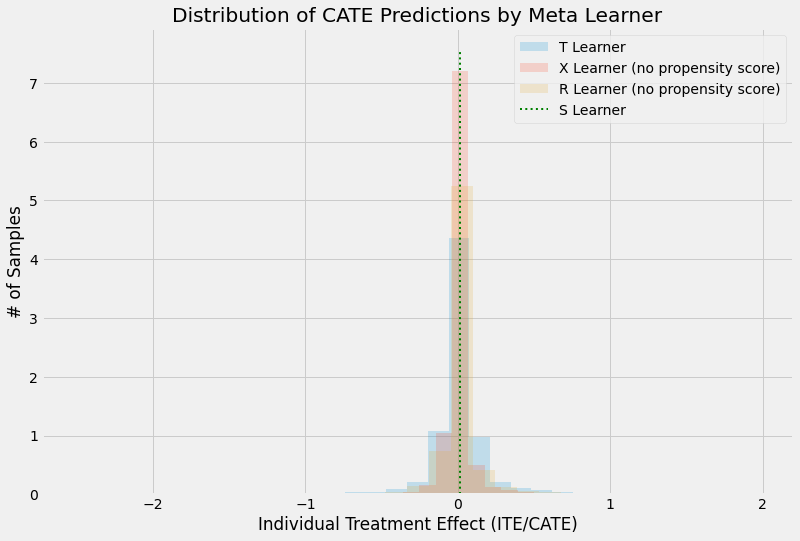

<Figure size 432x288 with 0 Axes>

In [22]:
plot_cate_results_1(cate_map)


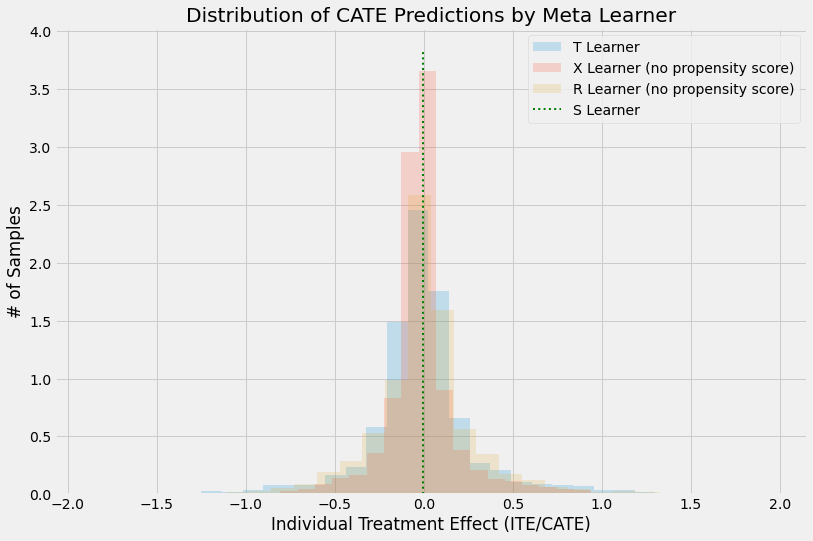

<Figure size 432x288 with 0 Axes>

In [21]:
plot_cate_results(cate_map_shuffled)


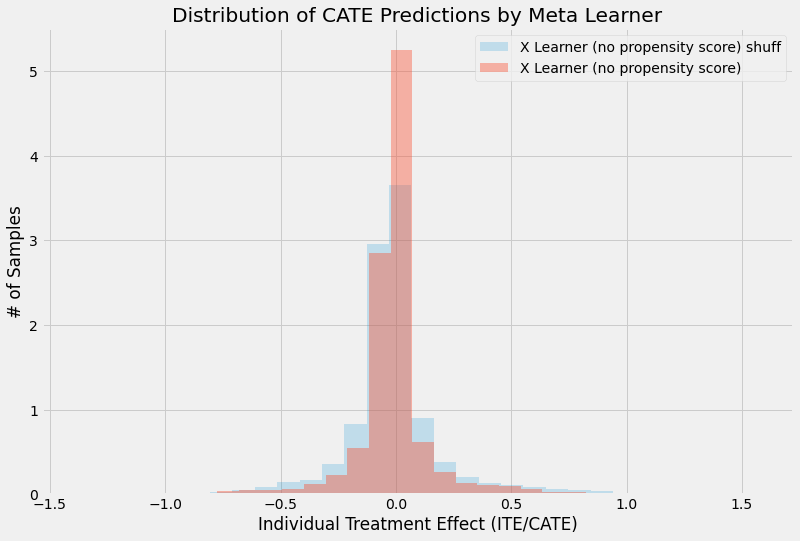

<Figure size 432x288 with 0 Axes>

In [32]:
plot_cate_results(cate_map_shuffled, cate_map)


In [70]:
# model-based feature importance


def get_feature_importances(X, learner, cate, method = 'auto'):
    feature_importances = learner.get_importance(X=X, 
                            tau=cate,
                            normalize=True, 
                            method='auto', 
                            features=list(X.columns))
    
#     feature_importances = dict(sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True))
    return feature_importances


def plot_feature_importances(X, learner, cate, top = 20, method = 'auto'):
    feature_importances = get_feature_importances(X, learner, cate, method)
    top_features = {}
    
    i = 0
    for feature, importance in feature_importances[1.0].items():
        top_features[feature] = importance
        
        i += 1
        if i == top:
            break
    
    top_feature_names = list(top_features.keys())
    
    learner.plot_importance(
        X = X[top_feature_names], 
        tau = cate, 
        normalize = True, 
        method = method, 
        features = top_feature_names
    )
    
#     learner.plot_shap_values(
#         X = X[top_feature_names], 
#         tau = cate, 
#         features = top_feature_names
#     )
    

def plot_shap_values(X, learner, cate, top = 20):
    shap_learner = learner.get_shap_values(X=X, tau=cate)
#     k = pd.Series(np.mean(np.abs(shap_learner[1.0]),axis=0), index = list(X.columns))
    k = pd.Series(np.mean(shap_learner[1.0],axis=0), index = list(X.columns))
    
    top_features = list(k.sort_values(ascending = False)[:top].index)
    learner.plot_shap_values(X=X[top_features], tau=cate, features=top_features)


learner = S
learner = T
learner = X
learner = R


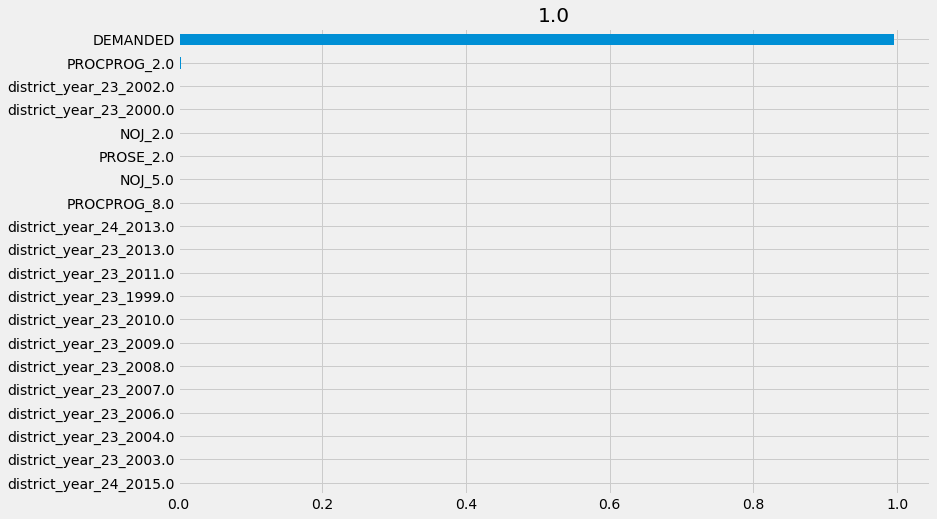

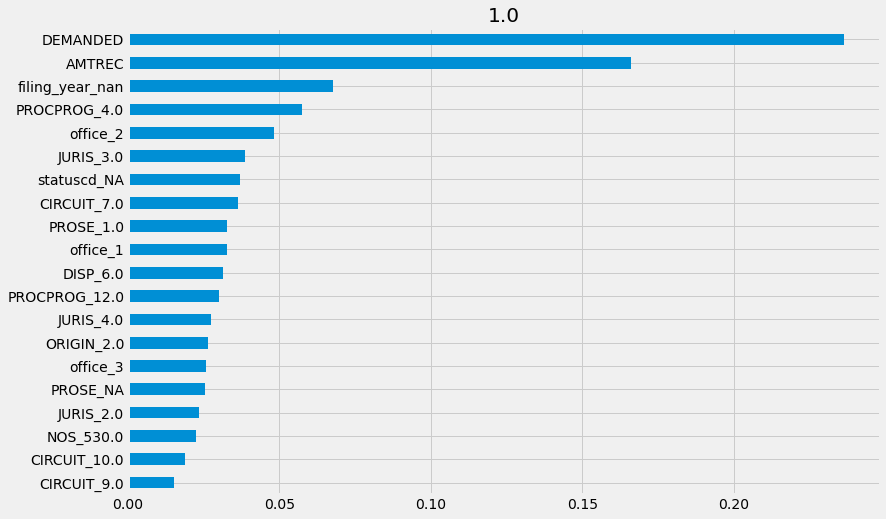

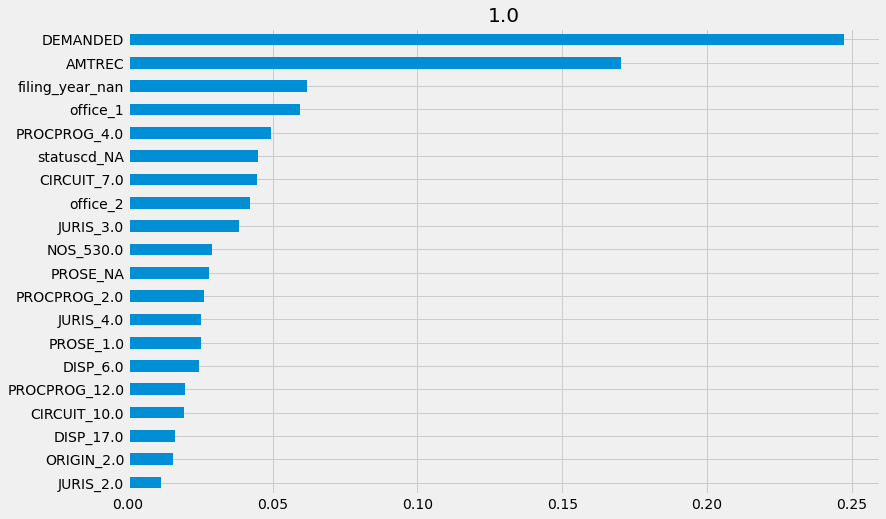

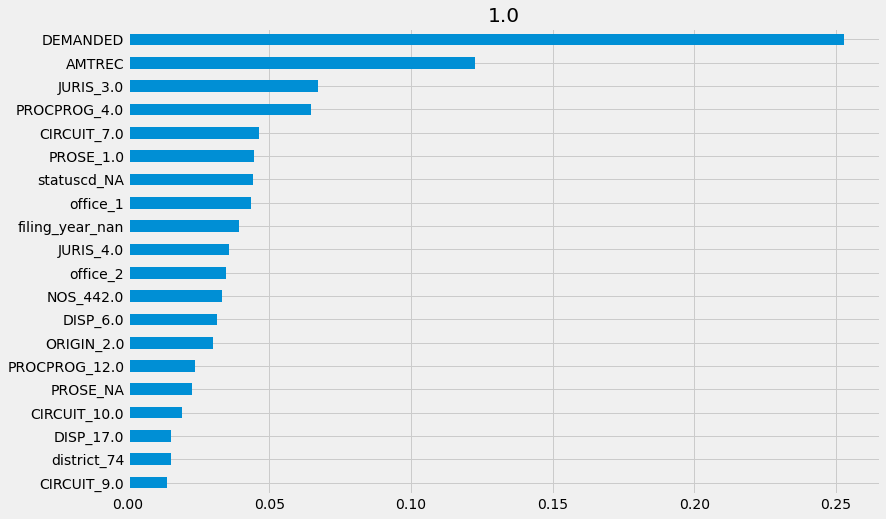

In [40]:
for kind in ['S', 'T', 'X', 'R']:
    learner = cate_map[kind][0]
    cate = cate_map[kind][1]
    
    print(f'learner = {kind}')
    plot_feature_importances(X, learner, cate, top = 20)


learner = S
learner = T
learner = X
learner = R


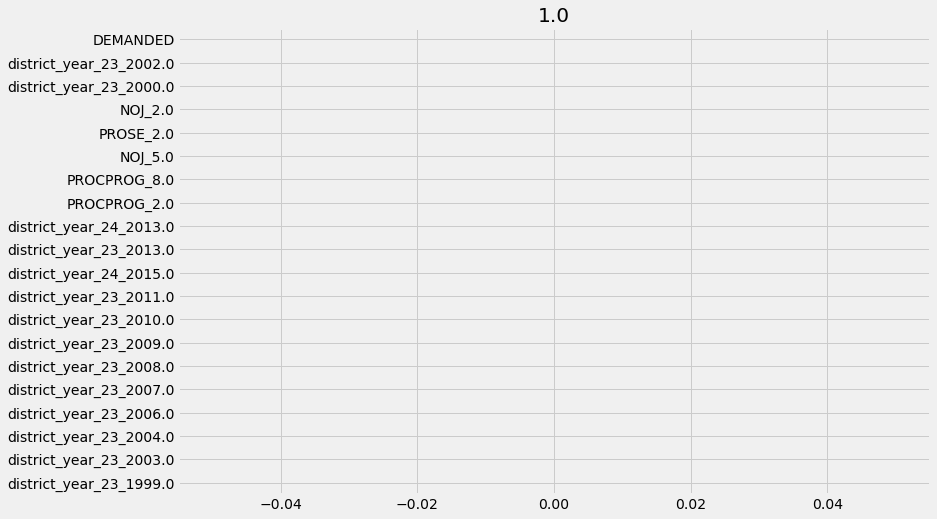

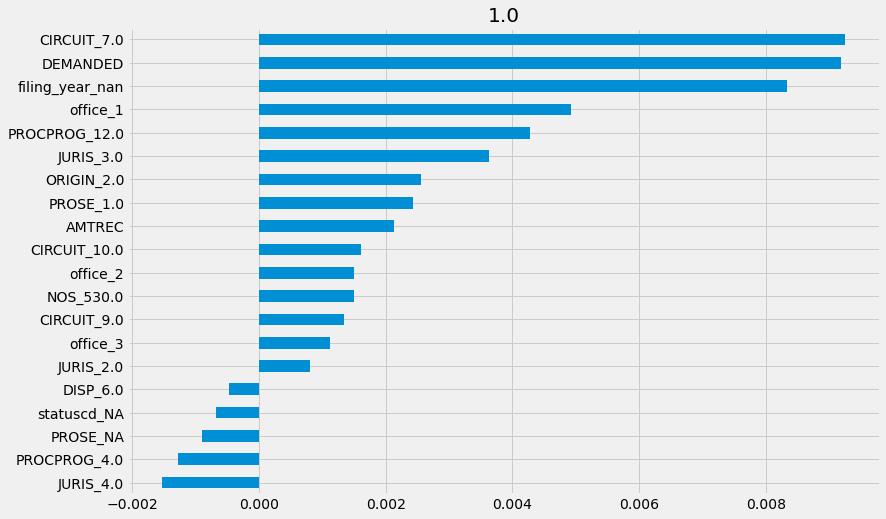

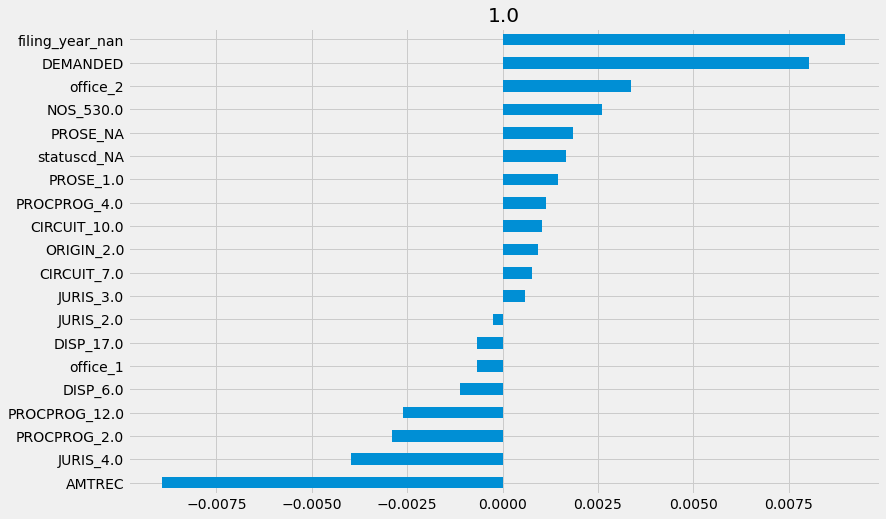

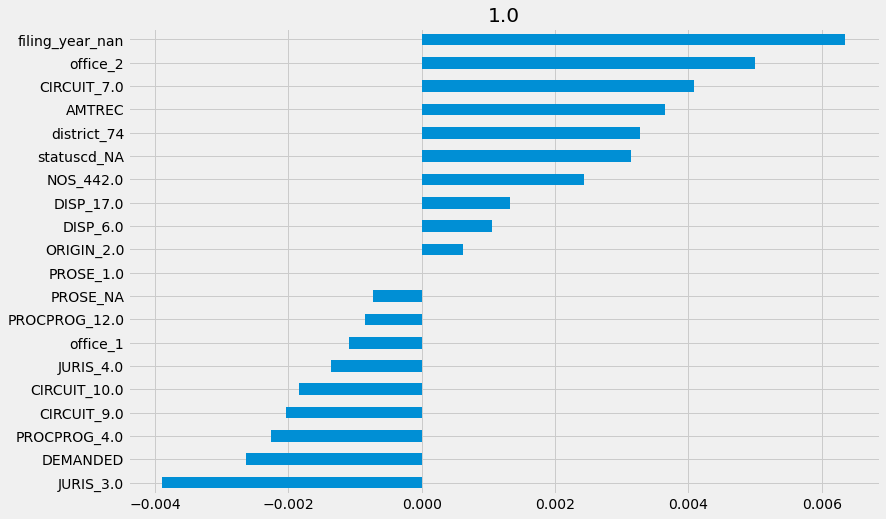

In [41]:
# permutation importance


for kind in ['S', 'T', 'X', 'R']:
    learner = cate_map[kind][0]
    cate = cate_map[kind][1]
    
    print(f'learner = {kind}')
    plot_feature_importances(X, learner, cate, top = 20, method = 'permutation')


learner = S


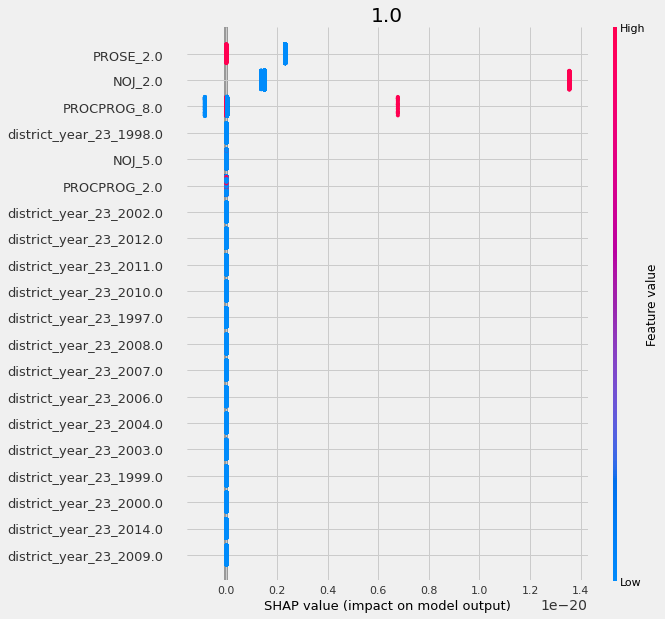

learner = T


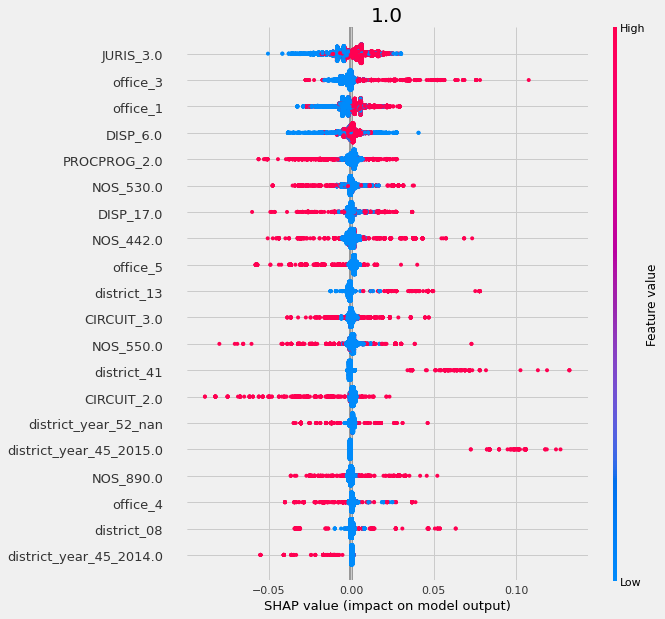

learner = X


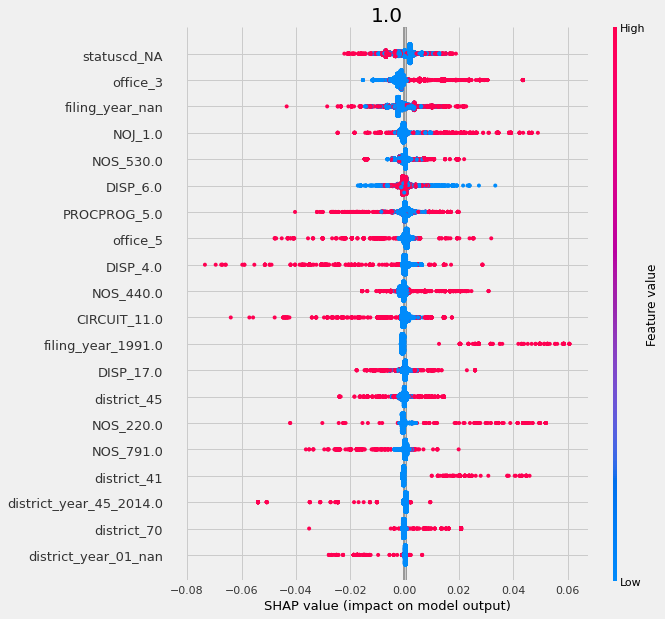

learner = R


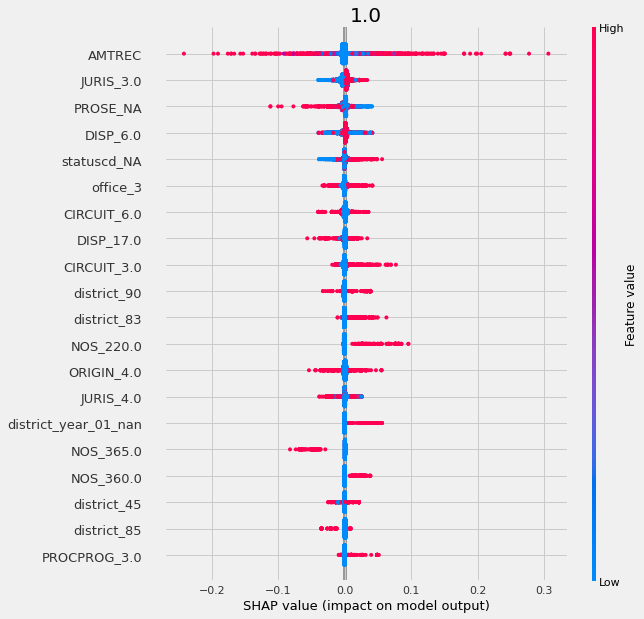

In [71]:
for kind in ['S', 'T', 'X', 'R']:
    learner = cate_map[kind][0]
    cate = cate_map[kind][1]
    
    print(f'learner = {kind}')
    plot_shap_values(X, learner, cate, top = 20)


In [37]:
# np.percentile(cate_map['X'][1], q = [0, 25, 50, 75, 100])

array([-1.65065274, -0.01640453,  0.00216481,  0.02278385,  1.57494798])

In [38]:
# np.unique(np.digitize(cate_map['X'][1], [-2, -0.1, 0, 0.1, 2]), return_counts = True)

(array([1, 2, 3, 4]), array([ 2379, 19851, 24724,  3046]))

In [54]:
np.percentile(cate_map['X'][1], q = [0, 25, 50, 75, 100])

array([-1.78718184, -0.02995654,  0.01438919,  0.12569056,  2.0253442 ])

In [55]:
np.unique(np.digitize(cate_map['X'][1], [-2, -0.1, 0, 0.1, 2]), return_counts = True)

(array([1, 2, 3, 4, 5]), array([139, 283, 307, 270,   1]))

In [30]:
df_sample['cate_S'] = cate_map['S'][1]
df_sample['cate_X'] = cate_map['X'][1]  
df_sample['cate_R'] = cate_map['R'][1]

threshold_cate_high = 0.1

df_sample['favors_plaintiff'] = np.zeros(df_sample.shape[0])
df_sample['favors_plaintiff'][df_sample['cate_X'] > threshold_cate_high] = 1

In [ ]:
import xgboost

In [31]:
model = xgboost.XGBClassifier()
clf_cols = cols_X + ['treatment']

model.fit(df_sample[clf_cols], df_sample['favors_plaintiff'])


[09:33:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
x = sorted(list(zip(clf_cols, list(model.feature_importances_))), key = lambda x: -x[1])

In [33]:
x[0:20]

[('district_81', 0.022233075),
 ('district_73', 0.020237563),
 ('district_year_3E_nan', 0.01852274),
 ('district_year_90_1990.0', 0.014093028),
 ('DISP_10.0', 0.013653526),
 ('NOS_950.0', 0.0135337),
 ('NOS_422.0', 0.012830322),
 ('PROSE_1.0', 0.012562141),
 ('district_year_11_nan', 0.012339432),
 ('NOS_864.0', 0.012159352),
 ('district_year_90_1991.0', 0.01184251),
 ('district_year_82_2012.0', 0.011531136),
 ('NOJ_4.0', 0.010737835),
 ('district_year_82_2011.0', 0.010132763),
 ('district_14', 0.0099110035),
 ('PROCPROG_9.0', 0.009658661),
 ('district_year_13_1997.0', 0.009435605),
 ('JURIS_2.0', 0.008611842),
 ('district_year_73_2013.0', 0.008581301),
 ('district_year_86_2015.0', 0.00831885)]

In [34]:
dict(x)['treatment']

0.0008076018

<AxesSubplot:xlabel='importance', ylabel='feature'>

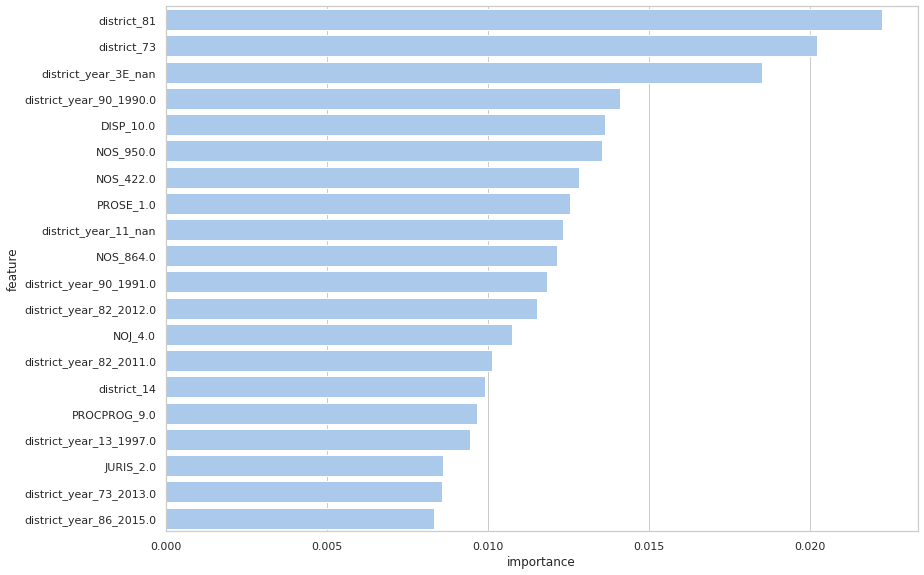

In [35]:
import seaborn as sns

plt.figure(figsize = (12, 9))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

sns.barplot(
    x="importance", 
    y="feature", 
    data=pd.DataFrame(x[0:20], columns = ['feature', 'importance']),
    label="importance", 
    color="b"
)

In [36]:
df_sample[df_sample['district_year_12_2009.0'] == 1]['favors_plaintiff']

145903    0.0
152547    0.0
100764    0.0
155346    0.0
144559    0.0
         ... 
118116    0.0
20813     0.0
146329    0.0
140109    0.0
118195    0.0
Name: favors_plaintiff, Length: 129, dtype: float64

In [ ]:
import shap

In [37]:
bg = shap.maskers.Independent(df_sample[clf_cols], max_samples=100)
explainer = shap.Explainer(model, bg)


 99%|===================| 49635/50000 [01:18<00:00]        

In [ ]:
shap_values = explainer(df_sample[clf_cols])

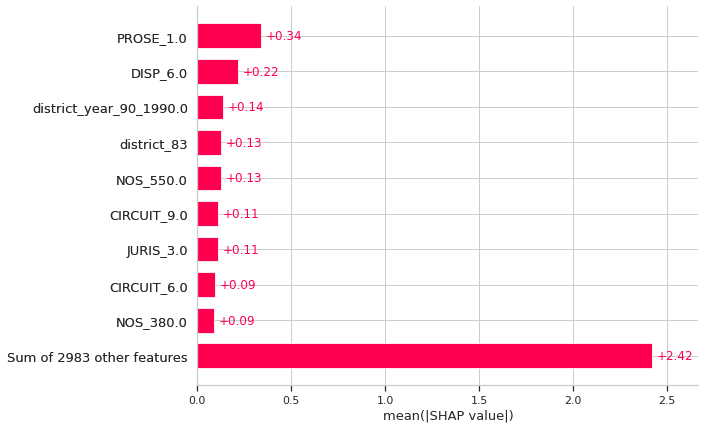

In [40]:
shap.plots.bar(shap_values)

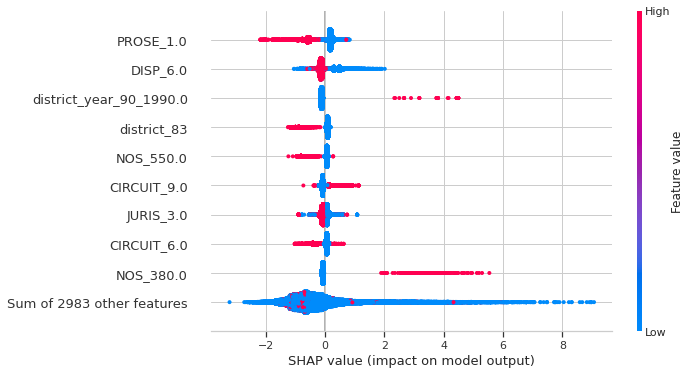

In [42]:
shap.plots.beeswarm(shap_values)
